In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import numpy as np
import cv2
import pandas as pd
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
import skimage
from skimage.transform import resize
import tensorflow as tf
import os
from tqdm import tqdm
import mediapipe as mp
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report 


In [2]:

import opendatasets as od
od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Downloading asl-alphabet.zip to .\asl-alphabet


100%|██████████| 1.03G/1.03G [33:43<00:00, 544kB/s]


In [2]:
train_dir = "../ASL-Classifier-Text-to-Speech-main/asl-alphabet/asl_alphabet_train/asl_alphabet_train/"
test_dir =  "../ASL-Classifier-Text-to-Speech-main/asl-alphabet/asl_alphabet_test/asl_alphabet_test/"


train_len = 87000
image_size=50

In [3]:
label_names = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N',
               'O','P','Q','R','S','T','U','V','W','X','Y','Z','del','nothing','space']

In [4]:
def get_image_list(dir=train_dir):
    # Get all the folder names
    image_folders = os.listdir(dir)
    # Dictionary to store the information
    image_dict = {}
    # Iterating over all the folders
    for folder in image_folders:
        # List of all images
        path='{a}{b}/'
        images = os.listdir(path.format(a=dir,b=folder))
        lst=[]
        for i in images:
            lst.append(i)
        image_dict[folder] =lst
    return image_dict

In [5]:
image_dict = get_image_list()
len(image_dict['C'])

3000

In [12]:
def get_connections_list():
   
    return {
        "WRIST_TO_THUMB_MCP": (0, 2),
        "WRIST_TO_THUMB_IP": (0, 3),
        "WRIST_TO_THUMB_TIP": (0, 4),
        "WRIST_TO_INDEX_FINGER_PIP": (0, 6),
        "WRIST_TO_INDEX_FINGER_DIP": (0, 7),
        "WRIST_TO_INDEX_FINGER_TIP": (0, 8),
        "WRIST_TO_MIDDLE_FINGER_PIP": (0, 10),
        "WRIST_TO_MIDDLE_FINGER_DIP": (0, 11),
        "WRIST_TO_MIDDLE_FINGER_TIP": (0, 12),
        "WRIST_TO_RING_FINGER_PIP": (0, 14),
        "WRIST_TO_RING_FINGER_DIP": (0, 15),
        "WRIST_TO_RING_FINGER_TIP": (0, 16),
        "WRIST_TO_PINKY_PIP": (0, 18),
        "WRIST_TO_PINKY_DIP": (0, 19),
        "WRIST_TO_PINKY_TIP": (0, 20),
        "THUMB_MCP_TO_THUMB_TIP": (2, 4),
        "INDEX_FINGER_MCP_TO_INDEX_FINGER_TIP": (5, 8),
        "MIDDLE_FINGER_MCP_TO_MIDDLE_FINGER_TIP": (9, 12),
        "RING_FINGER_MCP_TO_RING_FINGER_TIP": (13, 16),
        "PINKY_MCP_TO_PINKY_TIP": (17, 20),
        "THUMB_TIP_TO_INDEX_FINGER_MCP": (4, 5),
        "THUMB_TIP_TO_INDEX_FINGER_PIP": (4, 6),
        "THUMB_TIP_TO_INDEX_FINGER_DIP": (4, 7),
        "THUMB_TIP_TO_INDEX_FINGER_TIP": (4, 8),
        "THUMB_TIP_TO_MIDDLE_FINGER_MCP": (4, 9),
        "THUMB_TIP_TO_MIDDLE_FINGER_PIP": (4, 10),
        "THUMB_TIP_TO_MIDDLE_FINGER_DIP": (4, 11),
        "THUMB_TIP_TO_MIDDLE_FINGER_TIP": (4, 12),
        "THUMB_TIP_TO_RING_FINGER_MCP": (4, 13),
        "THUMB_TIP_TO_RING_FINGER_PIP": (4, 14),
        "THUMB_TIP_TO_RING_FINGER_DIP": (4, 15),
        "THUMB_TIP_TO_RING_FINGER_TIP": (4, 16),
        "THUMB_TIP_TO_PINKY_MCP": (4, 17),
        "THUMB_TIP_TO_PINKY_PIP": (4, 18),
        "THUMB_TIP_TO_PINKY_DIP": (4, 19),
        "THUMB_TIP_TO_PINKY_TIP": (4, 20)
    }

def get_distance(first, second):
    # Calculate distance from two coordinates
    return np.sqrt(
        (first.x - second.x) ** 2 
        + (first.y - second.y) ** 2 
        + (first.z - second.z) ** 2
    )

In [22]:
def create_connections_csv():
    # mediapipe code
    mp_drawing = mp.solutions.drawing_utils
    mp_hands = mp.solutions.hands

    # Run the functions to the get the image directory tree and connection dictionary
    #connections_dict = get_connections_list()
    image_dict = get_image_list()

    # List to store all the data to be put in the dataframe
    data = []

    with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands:
        # Iterating over all the folders
        for folder, image_names in image_dict.items():
            print(f"Processing folder: {folder}")
            # Iterating over all the images in folder
            row=[]
            for image_name in image_names:
                # Read image with OpenCV, flip, convert BGR to RGB
                image = cv2.imread(train_dir+f"{folder}/{image_name}")
                image = cv2.flip(image, 1)

                # Get coordinates from mediapipe
                results = hands.process(image)
                if not results.multi_hand_landmarks:
                    continue
                coordinates = results.multi_hand_landmarks[0].landmark

                
                
                for lmk in coordinates:
                    row.append(lmk.x)
                    row.append(lmk.y)
                    row.append(lmk.z)
                
                # Calculate distances and append the row to data
                #for _, values in connections_dict.items():
                    #row.append(get_distance(coordinates[values[0]], coordinates[values[1]]))
                row.append(folder)
                data.append(row)
            
    
    # Create dataframe
    #columns = list(connections_dict.keys())
    columns = list(range(1,64))
    columns.append('SIGN')
    df = pd.DataFrame(data=data, columns=columns)
    # Export to CSV file
    df.to_csv('connections.csv')

In [24]:
create_connections_csv()

In [4]:
def get_data(folder):
    X = np.empty((train_len, image_size, image_size, 3), dtype = np.float32)
    y = np.empty((train_len), dtype = int)
    cnt = 0
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28
            else:
                label = 29
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (image_size, image_size, 3))
                    img_arr = np.asarray(img_file).reshape((-1, image_size, image_size, 3))
                   
                    X[cnt] = img_arr
                    y[cnt] = label
                    cnt += 1
    return X,y
                             

letters, labels= get_data(train_dir)

print("The shape of letters is : ", letters.shape)

100%|██████████| 3000/3000 [00:29<00:00, 102.13it/s]

The shape of letters is :  (87000, 50, 50, 3)


In [21]:
labels

array([ 0,  0,  0, ..., 25, 25, 25])

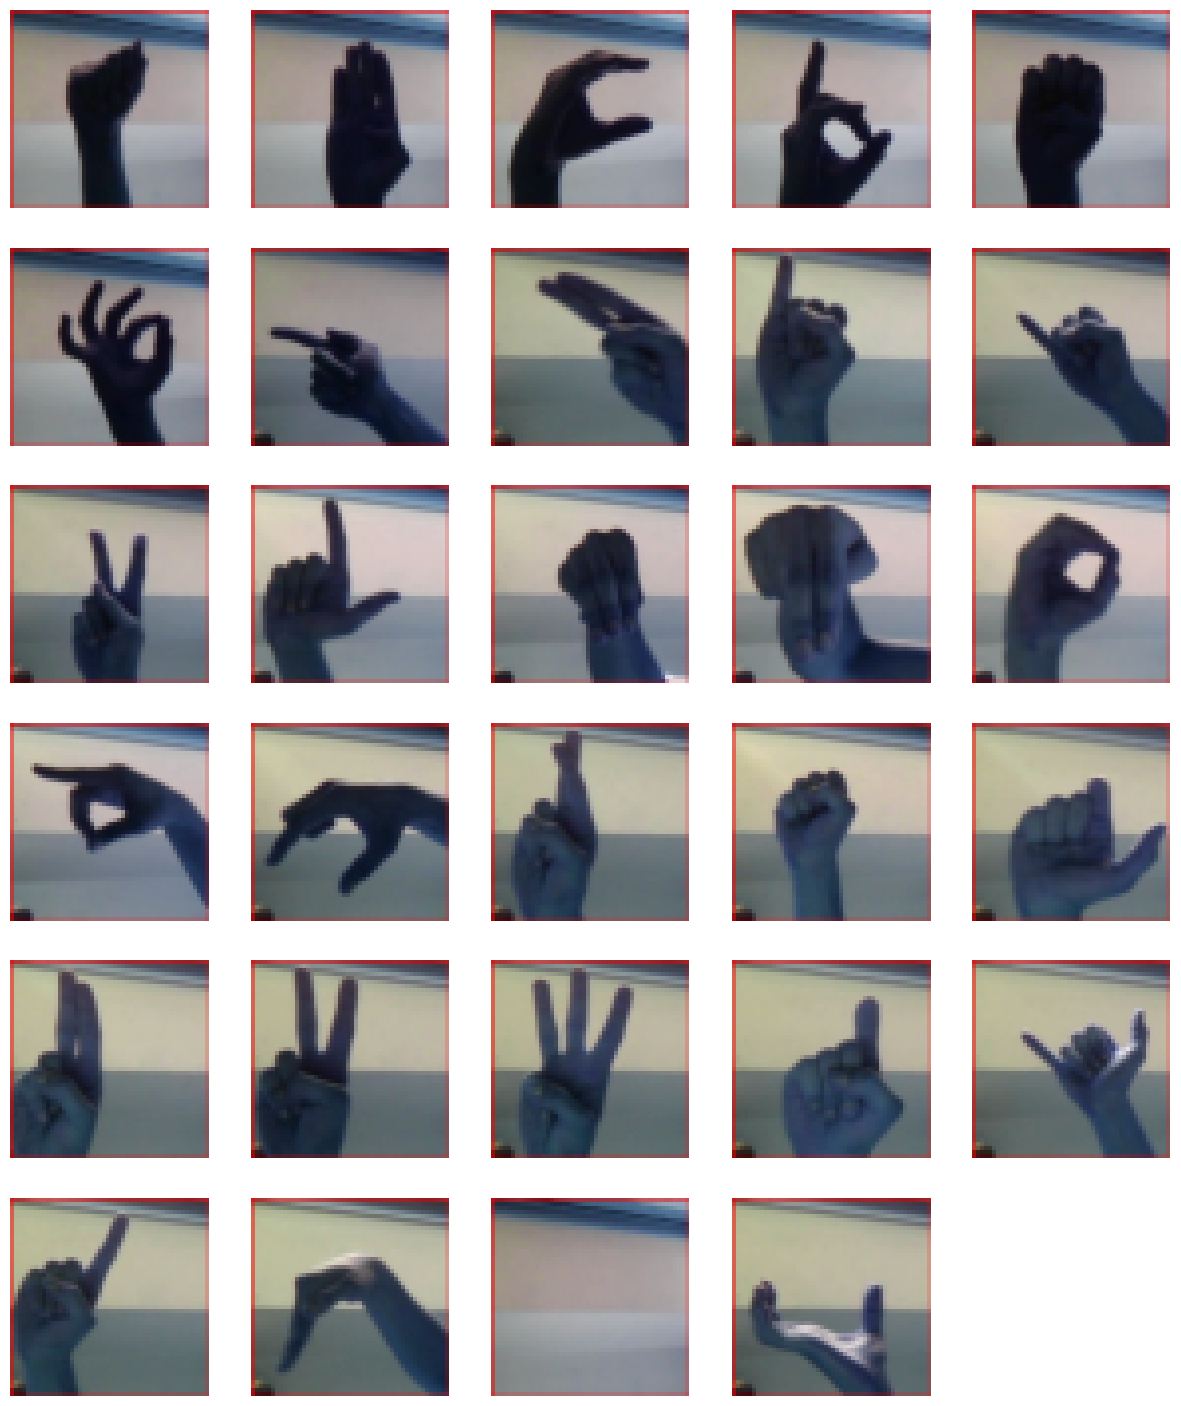

In [18]:
def plot_letter(letter):
    if letter.shape != (50, 50, 3):
        letter = letter.reshape(50, 50, 3)
    plt.imshow(letter)
    plt.axis('off')

    
def plot_letters(letters, cols=4):
    letters = np.array(letters)
    if len(letters.shape) == 1:
        letters = letters[None, :]
    m = letters.shape[0]
    
    rows = m // cols
    if m % cols != 0:
        rows += 1
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    if len(axes.shape) == 1:
        axes = axes[None, :]
    
    for i in range(rows):
        for j in range(cols):
            try:
                plt.sca(axes[i, j])  # set current axes
                letter = letters[i * cols + j]  # get letter
            except IndexError:
                plt.axis('off')
                continue
            plot_letter(letter)
    return fig, axes


_, idx = np.unique(labels, return_index=True)
plot_letters(letters[idx], cols=5)
for i in range(29):
    plt.subplot(6,5,i+1)
    plt.xlabel(label_names[i])

In [22]:
# from sklearn.preprocessing import LabelEncoder
# encoder=LabelEncoder()
# def preprocess_data(X, y,encoder=encoder):
#     normalised_X = X.astype('float32')/255.0
#     label_encoded=encoder.fit_transform(y)
    
#     x_train, x_test, y_train, y_test = train_test_split(normalised_X, label_encoded, test_size = 0.2)
#     x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size = 0.25)
    
#     return x_train, x_test,x_val, y_train, y_test,y_val

In [2]:
df = pd.read_csv("connections.csv", index_col=0)
df

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,SIGN
0,0.519470,0.514607,-1.024256e-06,0.405153,0.470778,-0.028747,0.359016,0.352746,-0.046244,0.359735,...,0.606661,0.307549,-0.103699,0.586637,0.362523,-0.084867,0.580486,0.409590,-0.066624,A
1,0.273371,0.664971,-7.713735e-07,0.193053,0.607663,-0.022878,0.146058,0.501920,-0.032636,0.139789,...,0.365625,0.459418,-0.071789,0.358470,0.514846,-0.057551,0.349311,0.563440,-0.034954,A
2,0.202675,0.599047,-2.879361e-07,0.317654,0.593669,-0.078389,0.432282,0.572750,-0.158276,0.482968,...,0.111980,0.402905,-0.307925,0.117081,0.341881,-0.324722,0.133890,0.281768,-0.327624,A
3,0.390913,0.638160,-5.259919e-07,0.297260,0.618009,-0.022545,0.228948,0.583545,-0.060256,0.182801,...,0.383067,0.483254,-0.250817,0.371182,0.547031,-0.259024,0.351299,0.609326,-0.256109,A
4,0.165630,0.508479,-6.412926e-07,0.274372,0.568001,-0.070547,0.383877,0.580099,-0.142956,0.448685,...,0.106238,0.368105,-0.289004,0.089078,0.384297,-0.310784,0.092573,0.390527,-0.322685,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16496,0.811372,0.687187,8.150327e-08,0.721732,0.693944,-0.049897,0.638851,0.636973,-0.080450,0.655027,...,0.779331,0.450041,-0.117576,0.795088,0.503629,-0.098621,0.803663,0.540020,-0.075375,Z
16497,0.666205,0.499983,-4.443125e-07,0.583419,0.508700,-0.041236,0.507254,0.450740,-0.061683,0.503226,...,0.654608,0.253528,-0.065342,0.664882,0.302448,-0.059016,0.679836,0.351057,-0.042936,Z
16498,0.664007,0.504481,-1.332474e-07,0.570236,0.514978,-0.037751,0.491753,0.444869,-0.053047,0.503062,...,0.642269,0.256753,-0.065126,0.655407,0.307103,-0.060611,0.670252,0.360711,-0.044993,Z
16499,0.650568,0.497627,2.425942e-07,0.571116,0.514553,-0.052602,0.489945,0.458855,-0.076080,0.492108,...,0.621583,0.249820,-0.110788,0.638181,0.306263,-0.096376,0.653621,0.360081,-0.070769,Z


In [3]:
# Feature selection
X = df.iloc[:,:-1] # Data
y = df.iloc[:,-1] # Class labels

y

0        A
1        A
2        A
3        A
4        A
        ..
16496    Z
16497    Z
16498    Z
16499    Z
16500    Z
Name: SIGN, Length: 16501, dtype: object

In [12]:
y1 = pd.get_dummies(y)

In [13]:
X_train, X_test, y_train, y_test =train_test_split(X, y1, test_size=0.15)

In [19]:
# ANN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Dense(units=len(X.columns)-1, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=60, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=df['SIGN'].nunique(), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], optimizer='adam')

# Early Stopping Callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

# Training the model
model.fit(
    x=X_train,
    y=y_train.values,
    epochs=5000,
    validation_data=(X_test, y_test),
    verbose=1,
    # callbacks=[early_stop]
)

Epoch 1/5000
439/439 [==============================] - 3s 4ms/step - loss: 2.3077 - accuracy: 0.3186 - val_loss: 1.4044 - val_accuracy: 0.6159
Epoch 2/5000
439/439 [==============================] - 1s 3ms/step - loss: 1.3840 - accuracy: 0.5845 - val_loss: 1.0578 - val_accuracy: 0.7007
Epoch 3/5000
439/439 [==============================] - 1s 3ms/step - loss: 1.1487 - accuracy: 0.6437 - val_loss: 0.9208 - val_accuracy: 0.7246
Epoch 4/5000
439/439 [==============================] - 1s 3ms/step - loss: 1.0435 - accuracy: 0.6742 - val_loss: 0.8426 - val_accuracy: 0.7496
Epoch 5/5000
439/439 [==============================] - 1s 3ms/step - loss: 0.9898 - accuracy: 0.6873 - val_loss: 0.8134 - val_accuracy: 0.7597
Epoch 6/5000
439/439 [==============================] - 1s 3ms/step - loss: 0.9331 - accuracy: 0.7042 - val_loss: 0.8007 - val_accuracy: 0.7589
Epoch 7/5000
439/439 [==============================] - 1s 3ms/step - loss: 0.8965 - accuracy: 0.7147 - val_loss: 0.7466 - val_accuracy:

In [20]:
#ANN model
print(f"Accuracy: {model.evaluate(X_test, y_test)[1] * 100:.2f}")

78/78 [==============================] - 0s 740us/step - loss: 0.2870 - accuracy: 0.9334
Accuracy: 93.34


In [22]:
import joblib 
joblib.dump(model,'ann.joblib')

['ann.joblib']

In [4]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.01)

In [14]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=20,
                                       n_estimators=500, oob_score=True)
model.fit(X_train,y_train)


RandomForestClassifier(max_depth=20, n_estimators=500, n_jobs=-1,
                       oob_score=True, random_state=42)

In [9]:
pred_values=model.predict(X_test)
pred_values

array(['A', 'U', 'G', 'nothing', 'E', 'J', 'N', 'N', 'I', 'H', 'G', 'F',
       'K', 'V', 'E', 'U', 'E', 'S', 'space', 'J', 'B', 'I', 'W', 'V',
       'V', 'W', 'K', 'F', 'E', 'K', 'S', 'I', 'G', 'A', 'X', 'I', 'E',
       'S', 'X', 'J', 'K', 'V', 'M', 'L', 'W', 'W', 'Y', 'U', 'J', 'E',
       'Z', 'G', 'A', 'G', 'A', 'del', 'G', 'N', 'G', 'G', 'J', 'V', 'A',
       'T', 'E', 'D', 'Q', 'I', 'G', 'Z', 'V', 'A', 'Q', 'O', 'L', 'F',
       'F', 'G', 'Y', 'Z', 'V', 'W', 'R', 'G', 'G', 'A', 'N', 'A', 'K',
       'R', 'K', 'I', 'Y', 'Y', 'A', 'Z', 'E', 'K', 'X', 'K', 'M', 'I',
       'V', 'Y', 'space', 'G', 'Y', 'L', 'Z', 'U', 'J', 'M', 'E', 'R',
       'L', 'G', 'J', 'Y', 'U', 'T', 'A', 'A', 'Y', 'K', 'R', 'T', 'E',
       'V', 'space', 'Z', 'E', 'A', 'I', 'T', 'Y', 'M', 'F', 'P', 'G',
       'G', 'A', 'K', 'W', 'E', 'Z', 'Q', 'L', 'A', 'G', 'Y', 'T', 'N',
       'R', 'E', 'J', 'A', 'B', 'Y', 'A', 'J', 'B', 'G', 'A', 'Z', 'A',
       'L'], dtype=object)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
acc = accuracy_score(y_test , pred_values)
prec = precision_score(y_test , pred_values, average="weighted")
rec = recall_score(y_test , pred_values, average="weighted")
f1 = f1_score(y_test , pred_values, average="weighted")
report = classification_report(y_test , pred_values)

print("\nValidation metrics:")
print("Accuracy: " + str(acc*100) + "%")
print("Precision: " + str(prec))
print("Recall: " + str(rec))
print("F1-Score: " + str(f1))

print("\nClassification Report:")
print(report)


Validation metrics:
Accuracy: 96.98795180722891%
Precision: 0.9748860827927094
Recall: 0.9698795180722891
F1-Score: 0.9696042338102457

Classification Report:
              precision    recall  f1-score   support

           A       0.94      1.00      0.97        15
           B       1.00      1.00      1.00         9
           D       1.00      1.00      1.00         2
           E       1.00      1.00      1.00        15
           F       1.00      0.67      0.80         3
           G       1.00      0.94      0.97        17
           H       0.88      1.00      0.93         7
           I       1.00      1.00      1.00         6
           J       1.00      1.00      1.00         7
           K       0.92      1.00      0.96        12
           L       1.00      1.00      1.00         6
           M       1.00      1.00      1.00         4
           N       1.00      1.00      1.00         1
           P       1.00      0.67      0.80         3
           R       1.00      

In [12]:
accuracy_score(y_test, pred_values)

0.9698795180722891

In [13]:
import joblib 
joblib.dump(model,'rf.joblib')

['rf.joblib']